In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

In [29]:
n_samples = 1_000
n_features = 3

X = np.random.uniform(-3, 3, (n_samples, n_features))
X = np.sort(X, axis=0)

$$
    f_1(\mathbf{x}) = x_1^2 + 2x_2 - 0.5 x_3^3 + 3
$$

In [30]:
f_1 = lambda x: x[0]**2 + 2*x[1] - 0.5*x[2]**2 + 3
y_1 = f_1(X.T)

$$
    f_2(\mathbf{x}) = \sin(5x_1) + \cos(7x_2) + 0.3\sin(10x_3)
$$

In [31]:
f_2 = lambda x: np.sin(5*x[0]) + np.cos(7*x[1]) + 0.3*np.sin(10*x[2])
y_2 = f_2(X.T)

Text(0.5, 1.0, 'f_1 and f_2')

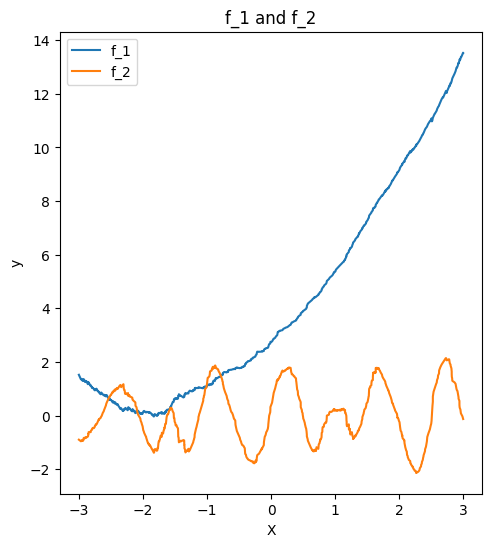

In [32]:
# plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(X[:, 0], y_1, label='f_1')
plt.plot(X[:, 0], y_2, label='f_2')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('f_1 and f_2')

## MLP

In [33]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from models import MLP
from tqdm.notebook import tqdm
from copy import deepcopy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_1, y_test_1, y_train_2, y_test_2 = train_test_split(X, y_1, y_2, test_size=0.2, random_state=SEED, shuffle=False)

X_train, X_test = torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_1, y_test_1 = torch.tensor(y_train_1, dtype=torch.float32).to(device), torch.tensor(y_test_1, dtype=torch.float32).to(device)
y_train_2, y_test_2 = torch.tensor(y_train_2, dtype=torch.float32).to(device), torch.tensor(y_test_2, dtype=torch.float32).to(device)

train_dataset_1 = TensorDataset(X_train, y_train_1)
train_dataset_2 = TensorDataset(X_train, y_train_2)
test_dataset_1 = TensorDataset(X_test, y_test_1)

In [35]:
batch_size = 32

train_loader_1 = DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True)
train_loader_2 = DataLoader(train_dataset_2, batch_size=batch_size, shuffle=True)
test_loader_1 = DataLoader(test_dataset_1, batch_size=batch_size, shuffle=False)
test_loader_2 = DataLoader(test_dataset_1, batch_size=batch_size, shuffle=False)

In [36]:
model_1 = MLP(
    n_features, 
    [64, 64],
    1,
    nn.ReLU()
).to(device)
model_2 = deepcopy(model_1)


print("Number of parameters: ", sum(p.numel() for p in model_1.parameters() if p.requires_grad))

optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=1e-3, weight_decay=0)
optimizer_2 = torch.optim.SGD(model_2.parameters(), lr=1e-3, weight_decay=0)

Number of parameters:  4481


In [37]:
from utils import train

train_losses_1, test_losses_1 = train(
    model_1, 
    train_loader_1, test_loader_1,
    optimizer_1, num_epochs=20,
    device=device
)
train_losses_2, test_losses_2 = train(
    model_2, 
    train_loader_2, test_loader_2,
    optimizer_2, num_epochs=50,
    device=device
)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [38]:
# Now we try to perform transfer learning, fitting the first model to the second function
model_2_transferred = deepcopy(model_1)

optimizer = torch.optim.Adam(model_2_transferred.parameters(), lr=1e-3, weight_decay=1e-5)

train_losses_2_transferred, test_losses_2_transferred = train(
    model_2_transferred, 
    train_loader_2, test_loader_2,
    optimizer, num_epochs=50,
    device=device
)

  0%|          | 0/50 [00:00<?, ?it/s]

In [39]:
from tabulate import tabulate

table = [
    ['Freshly trained model 2', train_losses_2[-1], test_losses_2[-1]],
    ['Model 2 transferred', train_losses_2_transferred[-1], test_losses_2_transferred[-1]]
]

print(tabulate(table, headers=['Model', 'Train loss', 'Test loss'], tablefmt='fancy_grid'))

╒═════════════════════════╤══════════════╤═════════════╕
│ Model                   │   Train loss │   Test loss │
╞═════════════════════════╪══════════════╪═════════════╡
│ Freshly trained model 2 │     0.957052 │     3.9067  │
├─────────────────────────┼──────────────┼─────────────┤
│ Model 2 transferred     │     0.379643 │     2.41717 │
╘═════════════════════════╧══════════════╧═════════════╛


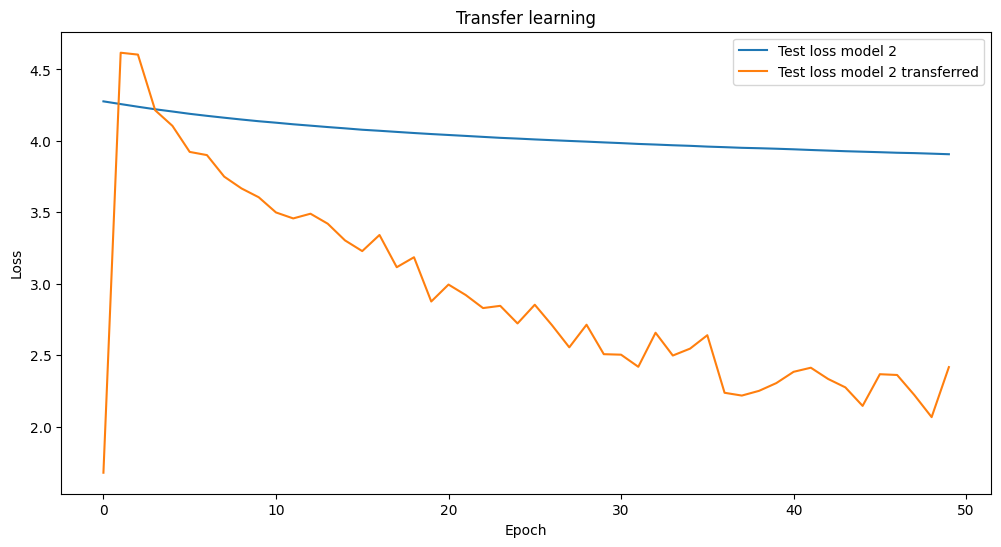

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(test_losses_2, label='Test loss model 2')
plt.plot(test_losses_2_transferred, label='Test loss model 2 transferred')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Transfer learning')
plt.show()